Частина 1

Для навчання моделі в цьому домашньому завданні використайте датасет FashionMNIST, а також вбудовані класи FashionMNIST та Dataloader для роботи з даними в PyTorch.

Визначити базову модель для навчання (чи хочете ви тренувати CNN чи MLP).
Визначте початкову кількість шарів та їх параметри.
Натренуйте модель і перевірте результат. Яке значення функції втрат, яка точність вашої моделі після навчання?
Частина 2

Визначте гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких точність на тестовому наборі буде найвищою.
Продемонструйте на яких класах та/або зображеннях найчастіше помиляється ваша модель.
(опціонально) Можете продемонструвати графіки залежностей між гіперпараметрами моделі і її точності.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

In [5]:
train_dataset = FashionMNIST('../datasets',
                               train=True,
                               download=True,
                               transform=transform)

validation_dataset = FashionMNIST('../datasets',
                                    train=False,
                                    transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 17379443.89it/s]


Extracting ../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301229.75it/s]


Extracting ../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5456085.31it/s]


Extracting ../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26690082.81it/s]

Extracting ../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



In [6]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


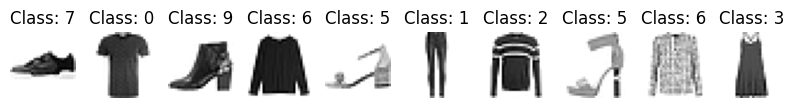

In [7]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())

    pltsize = 1
    plt.figure(figsize=(10 * pltsize, pltsize))

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
        plt.title('Class: ' + str(y_train[i].item()))

    break

In [8]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=264, bias=True)
    (5): ReLU()
    (6): Linear(in_features=264, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [14]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [15]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [16]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315034
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.635440
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.078821
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.545288
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.612868
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.699488
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.523453
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.567406
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.437412
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.569615

Validation set: Average loss: 0.4924, Accuracy: 8248/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.544556
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.429778
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.485787
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.479559
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.386433
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.359746
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.374713
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.432567
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.47

Text(0.5, 1.0, 'validation loss')

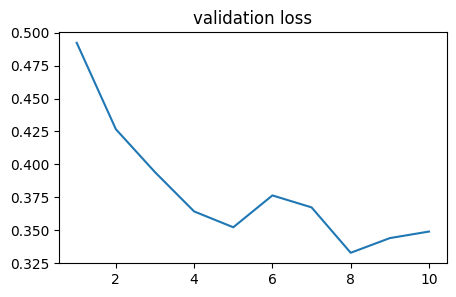

In [17]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

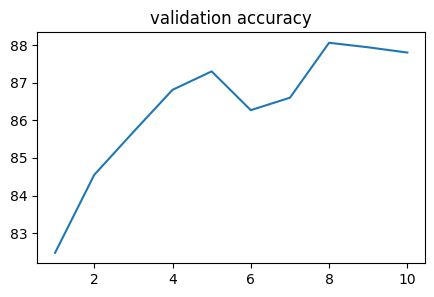

In [18]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

**By first 3 brute force trials with changing hyperparams I got:**

Validation set: Average loss: 0.3261, Accuracy: 8856/10000 (89%) hidden_sizes=[512, 256, 128], epoch = 10, lr = 0.1, momentum = 0.5

Validation set: Average loss: 0.3221, Accuracy: 8961/10000 (90%) hidden_sizes=[512, 512, 512, 256, 128], epoch = 15, lr = 0.1, momentum = 0.5

Validation set: Average loss: 0.3392, Accuracy: 8821/10000 (88%) hidden_sizes=[1024, 512, 256, 256, 64], epoch = 15, lr = 0.05, momentum = 0.25


**now let's do selection in a more smart way than guessing. first I will start with architecture selection**

In [21]:
architecture_list = [
    [128, 64],
    [128, 128, 64],
    [264, 128],
    [264, 128, 64],
    [512, 264, 128],
    [512, 512, 128],
    [512, 128, 64],
    [512, 512, 264, 128],
    [512, 512, 512, 256, 128]
]
architecture_result = {}

for elem in architecture_list:
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=elem).to(device)
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  epochs = 15
  lossv, accv = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
  architecture_result[str(elem)] = [lossv[-1], accv[-1]]

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.279641
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.915166
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.775754
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.595606
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.679485
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.319265
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.392656
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.332510
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.423876
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.483568

Validation set: Average loss: 0.4632, Accuracy: 8279/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.385662
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.613633
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.406499
Train Epoch: 2 [19200/60000 (32%)]	Lo

**We have trained model on several architectures with different number of layers and neurons per layer**

In [22]:
architecture_result

{'[128, 64]': [0.3357005038874129, tensor(88.0500)],
 '[128, 128, 64]': [0.35698077665317024, tensor(87.5600)],
 '[264, 128]': [0.3231813520096149, tensor(88.9400)],
 '[264, 128, 64]': [0.33821271414134574, tensor(88.6200)],
 '[512, 264, 128]': [0.3272831073176341, tensor(89.2000)],
 '[512, 512, 128]': [0.3314071084069285, tensor(88.8600)],
 '[512, 128, 64]': [0.33716629446072843, tensor(89.0800)],
 '[512, 512, 264, 128]': [0.3797895321929978, tensor(87.6200)],
 '[512, 512, 512, 256, 128]': [0.3630216030707129, tensor(88.7200)]}

**as we can see accuracy ranges from 87.5 to 89.2 with default values for lr and momentum for optimizer. Now let's compare the best architecture [512, 264, 128] with plenty of learning rates**

In [26]:
lr_list = [0.2, 0.1, 0.075, 0.05, 0.01]

lr_result = {}

for elem in lr_list:
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 264, 128]).to(device)
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=elem, momentum=0.5)
  epochs = 15
  lossv, accv = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
  lr_result[str(elem)] = [lossv[-1], accv[-1]]

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=264, bias=True)
    (3): ReLU()
    (4): Linear(in_features=264, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302523
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.552726
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.420191
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.836661
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.850785
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.593258
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.456573
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.466350
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.545093
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.376471

Validation set: Average loss: 0.5162, Accuracy: 8236/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.567106
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.249412
Train E

In [27]:
lr_result

{'0.2': [0.4010583411532904, tensor(88.4500)],
 '0.1': [0.4117262227296861, tensor(89.0200)],
 '0.075': [0.3704230969646455, tensor(89.3300)],
 '0.05': [0.37678168821305896, tensor(89.6400)],
 '0.01': [0.3588143292081754, tensor(88.0500)]}

**the best accuracy was achieved on learning rate = 0.05. let's make the same comparison for momentum in the optimizer**

In [28]:
moment_list = [0.5, 0.6, 0.7, 0.8, 0.9]

moment_result = {}

for elem in moment_list:
  model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 264, 128]).to(device)
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=elem)
  epochs = 15
  lossv, accv = [], []
  for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
  moment_result[str(elem)] = [lossv[-1], accv[-1]]

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=264, bias=True)
    (3): ReLU()
    (4): Linear(in_features=264, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292750
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.607910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.693245
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.323391
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.310992
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.245647
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.395546
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.938920
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.626036
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.498909

Validation set: Average loss: 0.4402, Accuracy: 8369/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.367884
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.353730
Train E

In [29]:
moment_result

{'0.5': [0.37286477497322723, tensor(89.2700)],
 '0.6': [0.36744841607684603, tensor(89.3300)],
 '0.7': [0.3876705148500695, tensor(88.4900)],
 '0.8': [0.40442426230208245, tensor(88.7400)],
 '0.9': [0.5567090734459655, tensor(84.7100)]}

**0.5 and 0.6 are the most optimal values for the momentum. we will select the higher value and train the network again with a higher number of epochs.**

In [35]:
model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 264, 128]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.6)

epochs = 25
lossv, accv = [], []
for epoch in range(1, epochs + 1):
  train(epoch)
  validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308239
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.628341
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.502140
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.573168
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.441342
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.353121
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.276740
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.461367
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.423955
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.439812

Validation set: Average loss: 0.4280, Accuracy: 8455/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.247381
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.596925
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.534864
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.222252
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.312927
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.593287
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.365043
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.485918
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.13

KeyboardInterrupt: ignored

**I have interrupted training when was achieved the highest accuracy 9004/10000 (90%).**

Text(0.5, 1.0, 'validation loss')

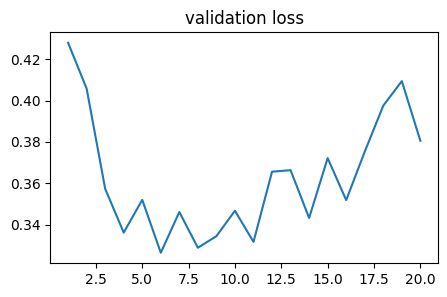

In [39]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,20+1), lossv)
plt.title('validation loss')

**but as we can see from the plot after 10th epoch model is overfitting, so these weights will not be optimal**

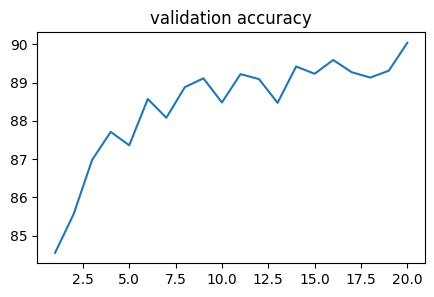

In [40]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,20+1), accv)
plt.title('validation accuracy');

In [41]:
def get_model_errors(model, loader):
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            _, predicted = torch.max(output.data, 1)

            for i in range(len(target)):
                label = target[i]
                prediction = predicted[i]

                if prediction != label:
                    class_correct[label] += 1
                class_total[label] += 1

    error_rates = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(10)]

    return error_rates

Text(0.5, 1.0, 'Error Rates by Class')

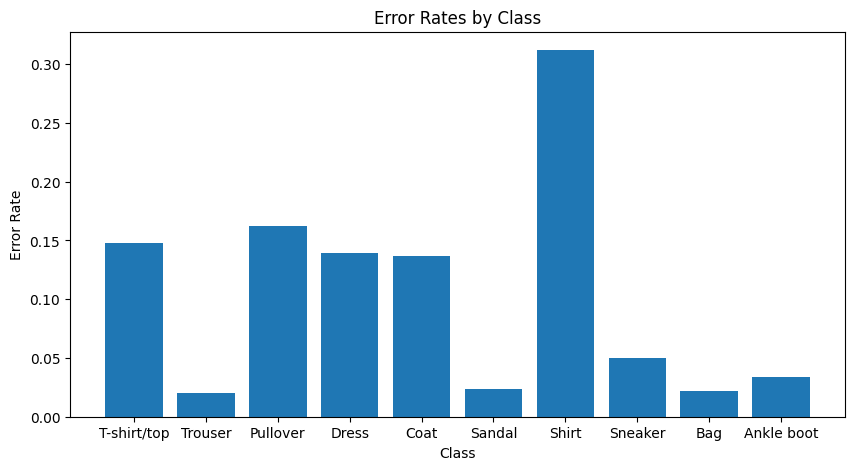

In [42]:
error_rates = get_model_errors(model, validation_loader)

plt.figure(figsize=(10, 5))
plt.bar(range(10), error_rates)
plt.xticks(range(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.xlabel('Class')
plt.ylabel('Error Rate')
plt.title('Error Rates by Class')

**from this plot we can see that highest error rate is on images with shirt and the lowest on trousers, bag, and sandal**